# Caso de aplicación

## Portafolio óptimo

### Librerías

In [1]:
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from matplotlib import cm
import scipy.optimize as opt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.optimize import minimize
from joblib import Parallel, delayed 
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize
from IPython.display import display, Markdown
from matplotlib.colors import LinearSegmentedColormap

### Obtención de datos

In [2]:
random.seed(42)
tickers=['WMT','AAPL','GOOGL','PG','XOM','KO','CMG','F']
tickers2 = ['VTI','VOO']

f_inicial='2020-01-01'
f_final='2024-11-24'

datos1=yf.download(tickers,f_inicial,f_final)['Adj Close']
datos2 = yf.download(tickers2,f_inicial,f_final)['Adj Close']

rt = datos1.pct_change().dropna()
rt2 = datos2.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  2 of 2 completed


### Cálculo de variables

In [3]:
mu = (rt.mean() * 252).values  # Rendimientos esperados
sigma = rt.cov().values  # Matriz de covarianza
sigma_inv = np.linalg.inv(sigma)  # Matriz de covarianza inversa
rf = 0.04413  # Tasa libre de riesgo
unos = np.ones(len(mu)) # Vector de unos
mu_rf = mu - np.dot(rf,unos) # Rendimientos esperados en exceso
n_assets = len(mu)

### Obtención de $w$

In [4]:
w = np.dot(sigma_inv,mu_rf)/ np.dot(unos.T,np.dot(sigma_inv,mu_rf))

### Cálculo del retorno, volatilidad y Sharpe Ratio del portafolio

- $\mu_p = w^{^T}\mu$
- $\sigma_p = \sqrt{ w^{T} \Sigma w}$
- $sr = \frac{\mu_p - r_f}{\sigma_p}$

In [5]:
ret = np.dot(w.T, mu) # Rendimiento esperado del portafolio
risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252) # Volatilidad del portafolio
sharpe = (ret - rf) / risk # Sharpe ratio

### Resultados

In [6]:
w_df = pd.DataFrame(w, index=rt.columns, columns=['w'])

print(f'Rendimiento esperado: {ret:.6%}')
print(f'Volatilidad: {risk:.6%}')
print(f'Ratio de sharpe: {sharpe:.6f}')

display(Markdown('### Valores del vector $w$:'))
display(w_df.T)

Rendimiento esperado: 35.668988%
Volatilidad: 27.528076%
Ratio de sharpe: 1.135422


### Valores del vector $w$:

Ticker,AAPL,CMG,F,GOOGL,KO,PG,WMT,XOM
w,0.321194,0.367774,-0.071291,-0.025011,-0.641888,0.076447,0.646384,0.32639


## Optimización de portafolios con scipy

In [7]:
# Función para minimizar (-Sharpe Ratio)
def neg_sharpe_ratio(w, mu, sigma, rf):
    port_return = np.dot(w, mu)  # Rendimiento esperado del portafolio
    port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe_ratio = (port_return - rf) / port_vol
    return -sharpe_ratio  # Negativo porque queremos maximizar

# Restricciones: Suma de pesos = 1
constraints = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
})

# Límites: Pesos entre 0 y 1 (no posiciones cortas)
bounds = tuple((0, 1) for _ in range(n_assets))

# Pesos iniciales (distribuidos uniformemente)
w0 = np.array([1 / n_assets] * n_assets)

# Optimización
result = opt.minimize(neg_sharpe_ratio, w0, args=(mu, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)

# Resultados
optimal_weights = result.x
optimal_sharpe = -result.fun
optimal_weights[optimal_weights < 0.000001] = 0

In [8]:
w_opt_df = pd.DataFrame(optimal_weights, index=rt.columns, columns=['w'])

ret_sci = np.dot(optimal_weights.T, mu) # Rendimiento esperado del portafolio
risk_sci = np.sqrt(np.dot(optimal_weights.T, np.dot(sigma, optimal_weights))) * np.sqrt(252) # Volatilidad del portafolio
sharpe_sci = (ret - rf) / risk # Sharpe ratio

print(f'Rendimiento esperado: {ret_sci:.6%}')
print(f'Volatilidad: {risk_sci:.6%}')
print(f'Ratio de sharpe: {sharpe_sci:.6f}')

display(w_opt_df.T)

Rendimiento esperado: 25.587477%
Volatilidad: 20.369700%
Ratio de sharpe: 1.135422


Ticker,AAPL,CMG,F,GOOGL,KO,PG,WMT,XOM
w,0.157707,0.278901,0.0,0.0,0.0,0.0,0.421951,0.141442


### Backtest de Portafolio óptimo vs S&P 500

In [9]:
portfolio_returns = np.dot(rt, w)
cumulative_return_port = (1 + portfolio_returns).cumprod()

portfolio_returns_opt = np.dot(rt, optimal_weights)
cumulative_return_port_opt = (1 + portfolio_returns_opt).cumprod()

cumulative_return_sp = (1 + rt2['VOO']).cumprod()

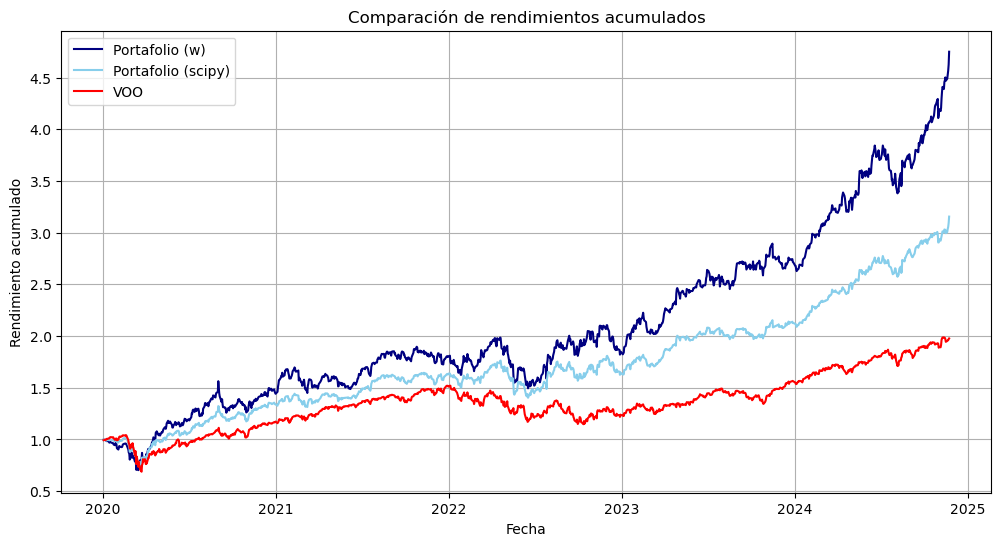

In [10]:
returns = pd.DataFrame({
    'portafolio': cumulative_return_port,
    'portfolio_opt': cumulative_return_port_opt,
    'VOO': cumulative_return_sp
})

plt.figure(figsize=(12, 6))

plt.plot(returns['portafolio'], label='Portafolio (w)', c = 'navy')
plt.plot(returns['portfolio_opt'], label='Portafolio (scipy)', c = 'skyblue')
plt.plot(returns['VOO'], label='VOO', c = 'red')

plt.title('Comparación de rendimientos acumulados') 
plt.xlabel('Fecha')
plt.ylabel('Rendimiento acumulado')

plt.legend()
plt.grid()

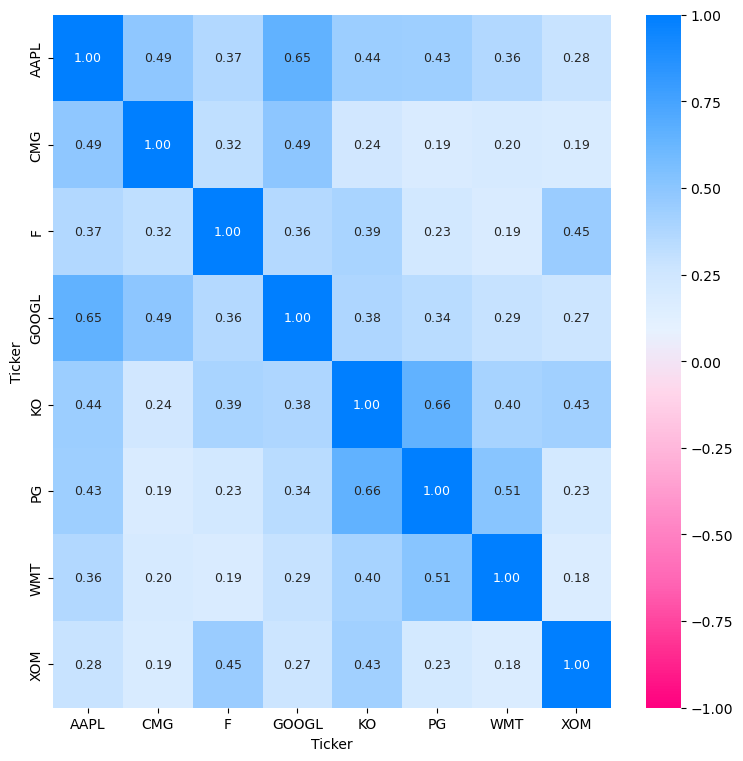

Promedio de la matriz es 0.4364144111809132
Promedio de la matriz sin diagonal principal es 0.3559021842067579


In [11]:
colors = ['#FF007F', '#FF3393', '#FF66B5', '#FF8AC7', '#FFB3D9', '#FFD6EB', 
          '#E6F2FF', '#CCE5FF', '#99CCFF', '#66B5FF', '#3399FF', '#007FFF']

custom_cmap = LinearSegmentedColormap.from_list("custom_pink_blue", colors)

c = rt.corr()
plt.figure(figsize=(9,9))
sns.heatmap(c, vmin = -1, vmax = 1, cmap = custom_cmap, annot = True, fmt = '.2f', annot_kws={"size": 9})
plt.show()

print('Promedio de la matriz es',c.values.mean())
print('Promedio de la matriz sin diagonal principal es',c.values[np.triu_indices(len(c), k=1)].mean())

### Simulación de portafolios

In [12]:
# Para las simulaciones
sigma = rt.cov()
n_port = 10000
n_act = len(rt.keys())

W = np.random.dirichlet((1,) * n_act, size=n_port)

# Obten los rendimientos
rendimientos = W.dot(rt.mean()) * 252

# Calcula las volatilidades
zeros = np.zeros(n_port)
for i in range(len(zeros)):
    zeros[i] = np.sqrt(W[i,:].dot(sigma).dot(W[i,:])) * np.sqrt(252)
volatility = zeros

# Sharpe
sharpe = (rendimientos - rf) / volatility

# Data frame de resultados
resultados = pd.DataFrame({
    'rend': rendimientos,
    'vol': volatility,
    'sharpe': sharpe
})
pesos = pd.DataFrame(W, columns=rt.keys())
resultados = pd.concat([resultados, pesos], axis=1)

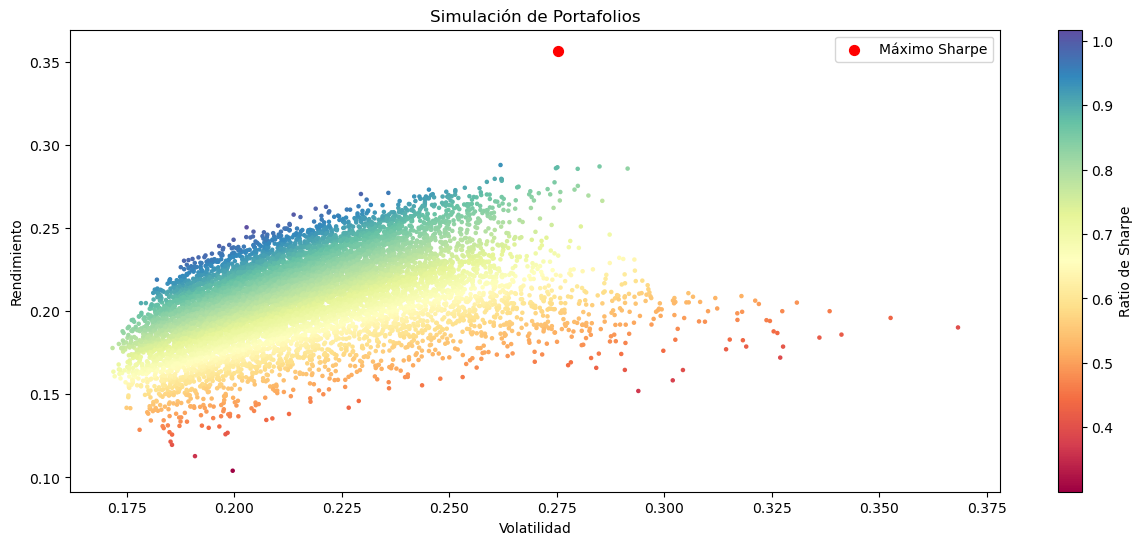

In [13]:
# Crear el gráfico con matplotlib
fig, ax = plt.subplots(figsize=(15, 6))

# Crear la normalización y el mapa de colores
norm = Normalize(vmin=min(sharpe), vmax=max(sharpe))
cmap = matplotlib.colormaps['Spectral']

# Crear el scatter plot
sc = ax.scatter(resultados['vol'], resultados['rend'], c=sharpe, cmap=cmap, norm=norm, s=5)
plt.scatter(risk, ret, color='red', s=50, label='Máximo Sharpe')

# Añadir la barra de colores
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Ratio de Sharpe')

# Añadir etiquetas
ax.set_title('Simulación de Portafolios')
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Rendimiento')

# Mostrar el gráfico
plt.legend()
plt.show()

## Comparación pesos óptimos vs pesos aleatorios

### Funciones

In [14]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'SPOT', 'SBUX', 'JPM', 'AXP', 'MCD', 'KO', 
           'NFLX', 'CMG', 'CP', 'WMT', 'V', 'GLD', 'BLK', 'PG', 'JNJ', 'TMUS', 'MA', 'BX', 'LULU', 'DPZ', 'BAC', 
           'FDX', 'DIS', 'GE', 'HSY', 'HP', 'COST', 'HD', 'K', 'ADBE', 'CSCO', 'T', 'F', 'NKE', 'CVX', 'XOM', 'PYPL', 
           'PEP', 'PFE', 'MRNA', 'RL', 'AZN', 'BABA', 'VZ', 'WBD', 'HSBC', 'UBER']

def simulate_portfolio_opt(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.dot(sigma_inv, mu_rf) / np.dot(unos.T, np.dot(sigma_inv, mu_rf))

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 1000  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_opt)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_opt = [result[0] for result in results]
volatilidades_opt = [result[1] for result in results]
sharpe_ratios_opt = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  8 of 8 completedd
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  8 of 8 completedd
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  14 of 14 completed
[***********

In [15]:
def simulate_portfolio(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.dirichlet(np.ones(len(mu)), size=1)[0]

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 1000  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos = [result[0] for result in results]
volatilidades = [result[1] for result in results]
sharpe_ratios = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  5 of 5 completedd
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  15 of 15 completed
[*********

In [16]:
def simulate_portfolio_short(i, tickers, rf):
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.uniform(-3, 3, len(mu))
    w /= np.sum(w)

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 1000  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_short)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_short = [result[0] for result in results]
volatilidades_short = [result[1] for result in results]
sharpe_ratios_short = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  8 of 8 completeded
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  8 of 8 completeded
[**********************86%****************       ]  6 of 7 completeded
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  12 of 12 completed
[*********

In [17]:
def simulate_portfolio_opt(i, tickers, rf):
    # Selección aleatoria del tamaño de la muestra y de los tickers
    sample_size = random.randint(5, 15)
    random_tickers = random.sample(tickers, sample_size)

    # Descarga de datos
    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    n_assets = len(mu)

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = np.dot(w, mu)  # Rendimiento esperado del portafolio
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
        sharpe_ratio = (port_return - rf) / port_vol
        return -sharpe_ratio  # Negativo porque queremos maximizar

    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.array([1 / n_assets] * n_assets)

    # Optimización
    result = opt.minimize(neg_sharpe_ratio, w0, args=(mu, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)

    # Resultados
    optimal_weights = result.x
    optimal_weights[optimal_weights < 0.000001] = 0  # Eliminar pesos numéricamente cercanos a cero

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(optimal_weights.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(optimal_weights.T, np.dot(sigma, optimal_weights))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, optimal_weights

# Número de simulaciones
n_simulations = 1000

# Ejecutar simulaciones en paralelo
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_opt)(i, tickers, rf) for i in range(n_simulations))

# Extraer resultados
retornos_sci = [result[0] for result in results]
volatilidades_sci = [result[1] for result in results]
sharpe_ratios_sci = [result[2] for result in results]
# pesos_sci = [result[3] for result in results]


[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  9 of 9 completeddd
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  5 of 5 completedd
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  6 of 6 completedd
[*********************100%***********************]  8 of 8 completedd
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  6 of 6 completeded
[*********************100%***********************]  12 of 12 completed
[************

### DataFrames

In [18]:
# Fórmula de w
metricas_optimas_df = pd.DataFrame({
    'rendimiento': retornos_opt,
    'volatilidad': volatilidades_opt,
    'sharpe': sharpe_ratios_opt
})

metricas_optimas_df = metricas_optimas_df.query('sharpe > 0')
metricas_optimas_df

,rendimiento,volatilidad,sharpe
0,1.099082,0.616901,1.710083
1,0.445284,0.259011,1.548795
2,1.075232,0.966884,1.066418
3,2.488489,1.864164,1.311236
4,0.524251,0.467266,1.027510
...,...,...,...
995,1.197445,0.786797,1.465836
996,0.188375,0.194904,0.740080
997,1.590464,0.778165,1.987155
998,0.525744,0.409204,1.176954


In [19]:
# Pesos random
metricas_df = pd.DataFrame({
    'rendimiento': retornos,
    'volatilidad': volatilidades,
    'sharpe': sharpe_ratios
})

In [20]:
# Pesos random con posiciones cortas
metricas_df_short = pd.DataFrame({
    'rendimiento': retornos_short,
    'volatilidad': volatilidades_short,
    'sharpe': sharpe_ratios_short
})

In [21]:
# Pesos con scipy
metricas_df_scipy = pd.DataFrame({
    'rendimiento': retornos_sci,
    'volatilidad': volatilidades_sci,
    'sharpe': sharpe_ratios_sci
})

## Histogramas de ratio de Sharpe

### Sharpe con fórmula de $w$ vs Sharpe con pesos aleatorios

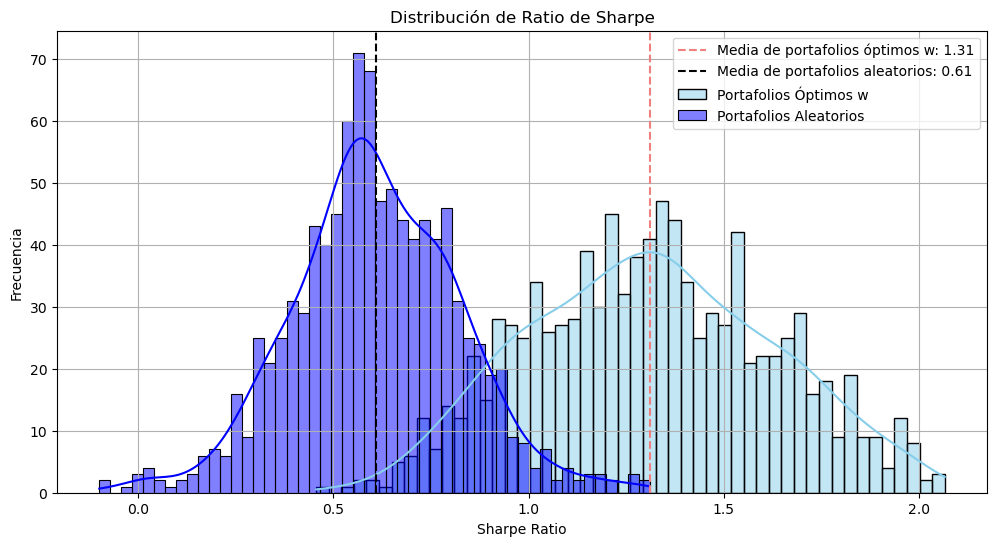

In [22]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='skyblue',
    label='Portafolios Óptimos w'
)

sns.histplot(
    data=metricas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
random_mean = metricas_df['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos w: {opt_mean:.2f}')
plt.axvline(random_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {random_mean:.2f}')

plt.legend()
plt.title('Distribución de Ratio de Sharpe')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

### Sharpe con fórmula de $w$ vs Sharpe con pesos aleatorios permitiendo shorts

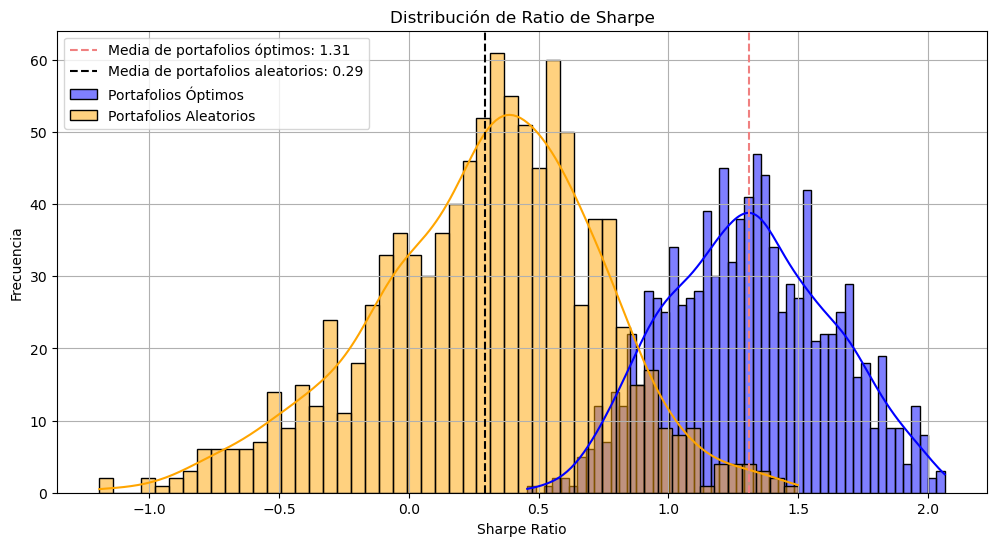

In [23]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
short_mean = metricas_df_short['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Ratio de Sharpe')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

### Sharpe con scipy vs Sharpe con pesos aleatorios

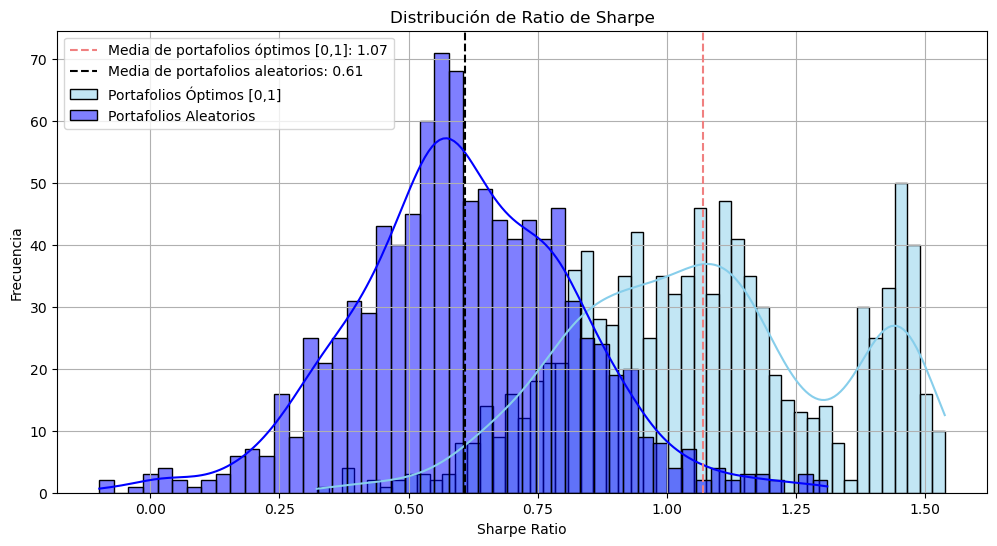

In [24]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_df_scipy['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='skyblue',
    label='Portafolios Óptimos [0,1]'
)

sns.histplot(
    data=metricas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Aleatorios'
)

sci_mean = metricas_df_scipy['sharpe'].mean()
random_mean = metricas_df['sharpe'].mean()

plt.axvline(sci_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos [0,1]: {sci_mean:.2f}')
plt.axvline(random_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {random_mean:.2f}')

plt.legend()
plt.title('Distribución de Ratio de Sharpe')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

## Histograma de rendimientos

In [25]:
metricas_optimas_df_filter = metricas_optimas_df.query('rendimiento > -0.5 and rendimiento < 2 and volatilidad < 1.5')
metricas_df_filter = metricas_df.query('rendimiento > -0.5 and rendimiento < 2')
metricas_df_short_filter = metricas_df_short.query('rendimiento > -0.5 and rendimiento < 2 and volatilidad < 1.5')

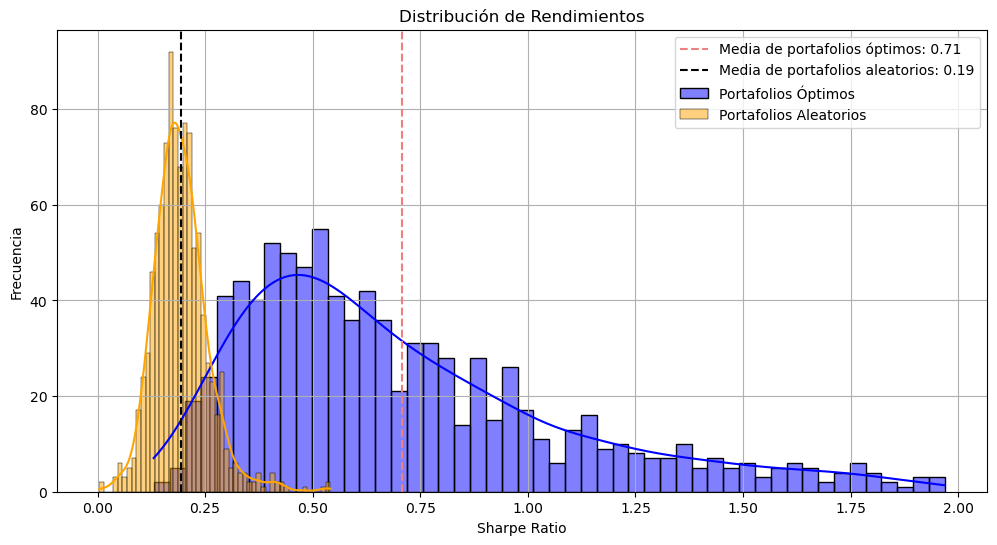

In [26]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['rendimiento'].mean()
short_mean = metricas_df_filter['rendimiento'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Rendimientos')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

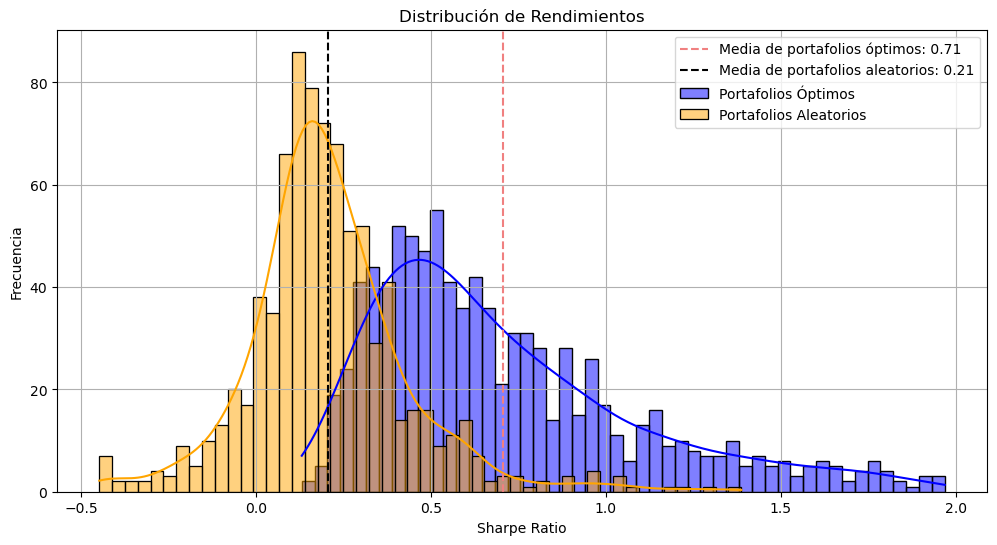

In [27]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short_filter['rendimiento'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['rendimiento'].mean()
short_mean = metricas_df_short_filter['rendimiento'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Rendimientos')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

## Histograma de volatilidades

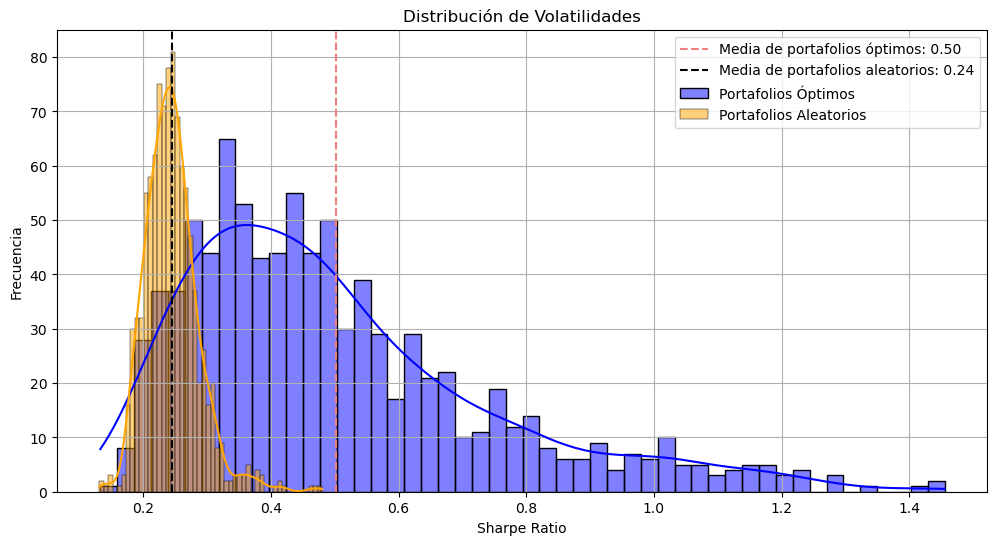

In [28]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['volatilidad'].mean()
short_mean = metricas_df_filter['volatilidad'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Volatilidades')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

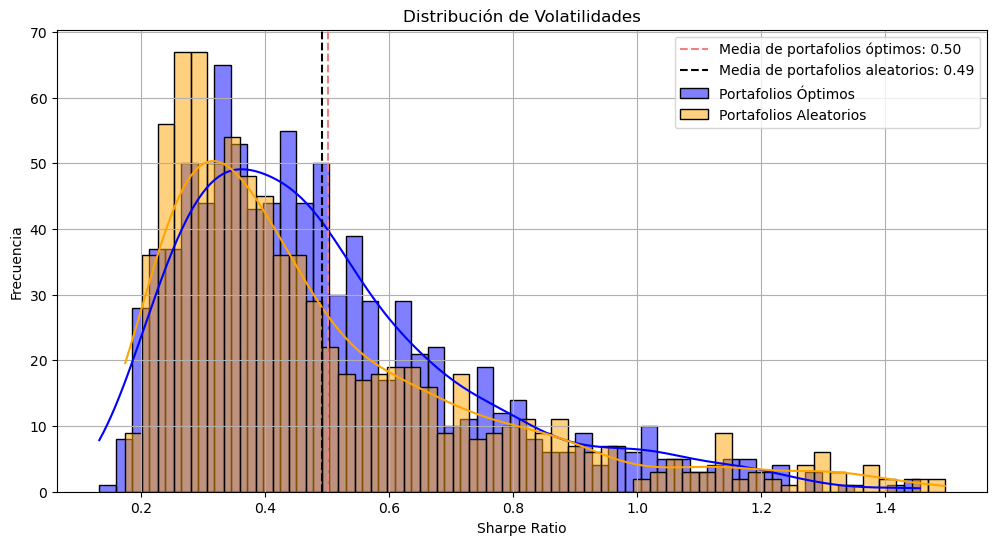

In [29]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df_filter['volatilidad'].mean()
short_mean = metricas_df_short_filter['volatilidad'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Volatilidades')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

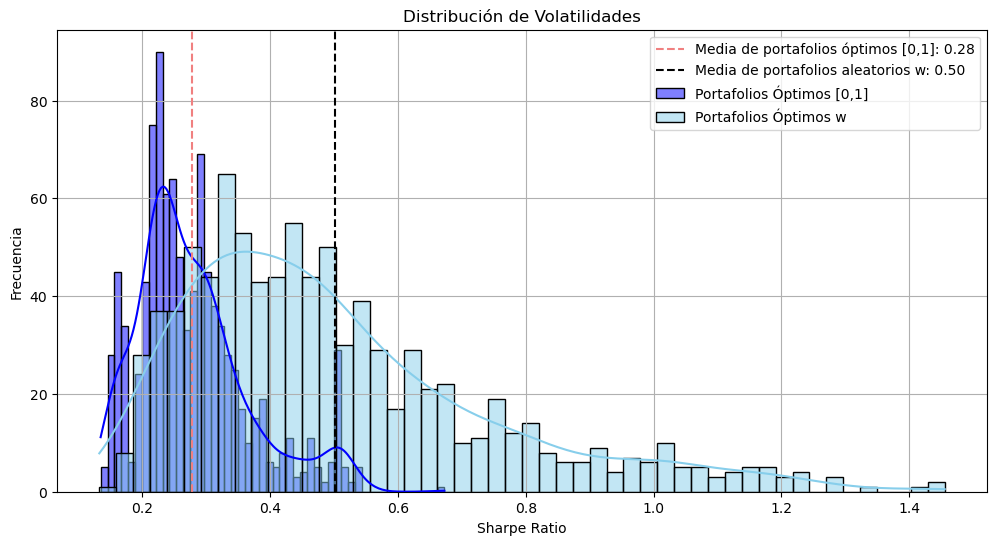

In [30]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_df_scipy['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos [0,1]'
)

sns.histplot(
    data=metricas_optimas_df_filter['volatilidad'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='skyblue',
    label='Portafolios Óptimos w'
)

sci_vol = metricas_df_scipy['volatilidad'].mean()
short_mean = metricas_optimas_df_filter['volatilidad'].mean()

plt.axvline(sci_vol, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos [0,1]: {sci_vol:.2f}')
plt.axvline(short_mean, color='black', linestyle='--', label=f'Media de portafolios aleatorios w: {short_mean:.2f}')

plt.legend()
plt.title('Distribución de Volatilidades')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

## Boxplots

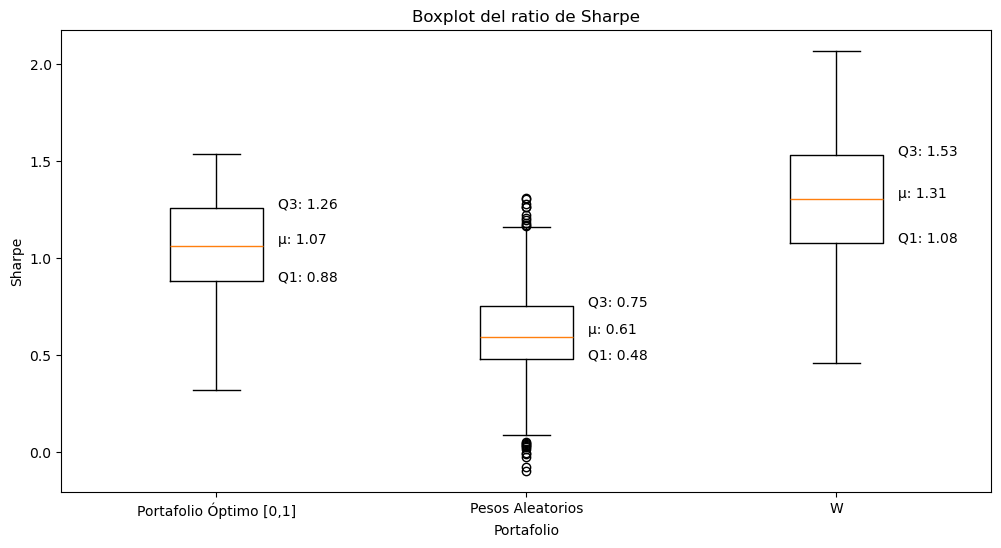

In [72]:
plt.figure(figsize=(12, 6))
# Preparar los datos
data = [
    metricas_df_scipy['sharpe'],
    metricas_df['sharpe'],
    metricas_optimas_df['sharpe']
]

labels = ['Portafolio Óptimo [0,1]', 'Pesos Aleatorios', 'W']

# Crear el boxplot
plt.boxplot(data, vert=True, tick_labels=labels)

# Añadir anotaciones para cada grupo de datos
for i, group in enumerate(data):
    # Calcular estadísticas
    mean = np.mean(group)
    q1 = np.percentile(group, 25)
    q3 = np.percentile(group, 75)
    
    # Añadir texto para cada estadística
    plt.text(i + 1.2, q3, f"Q3: {q3:.2f}", fontsize=10, color='black')
    plt.text(i + 1.2, mean, f"μ: {mean:.2f}", fontsize=10, color='black')
    plt.text(i + 1.2, q1, f"Q1: {q1:.2f}", fontsize=10, color='black')


# Personalizar el gráfico
plt.title('Boxplot del ratio de Sharpe')
plt.xlabel('Portafolio')
plt.ylabel('Sharpe')
plt.show()